In [3]:
import torch
from torch_geometric.data import Data

import torch.nn as nn
import torch_geometric.nn as pyg_nn

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

import numpy as np

In [4]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NVIDIA GeForce GTX 1650
Using device: cuda


In [5]:
# Constants
L = 1.0
EI = 1
Q = -2000

num_nodes = 10
dx = L / (num_nodes - 1) # Distance between nodes

In [56]:
edge_index = []
for i in range(num_nodes - 1):
    edge_index.append([i, i + 1]) # Forward connection
    edge_index.append([i + 1, i]) # Backward connection (undirected graph)

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor([dx] * edge_index.shape[1], dtype=torch.float).view(-1, 1)

node_pos = torch.tensor([[i * dx] for i in range(num_nodes)], dtype=torch.float).requires_grad_()
bc = torch.zeros((num_nodes, 1))
forces = torch.full((num_nodes, 1), Q)
lbc = (node_pos == 0)
rbc = (node_pos == 1)

bc[lbc] = 1
bc[rbc] = 2

forces[lbc] = 0

x = torch.cat((node_pos, bc, forces), dim=1)
print(x)

beam_graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
print(beam_graph)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 1.1111e-01,  0.0000e+00, -2.0000e+03],
        [ 2.2222e-01,  0.0000e+00, -2.0000e+03],
        [ 3.3333e-01,  0.0000e+00, -2.0000e+03],
        [ 4.4444e-01,  0.0000e+00, -2.0000e+03],
        [ 5.5556e-01,  0.0000e+00, -2.0000e+03],
        [ 6.6667e-01,  0.0000e+00, -2.0000e+03],
        [ 7.7778e-01,  0.0000e+00, -2.0000e+03],
        [ 8.8889e-01,  0.0000e+00, -2.0000e+03],
        [ 1.0000e+00,  2.0000e+00, -2.0000e+03]], grad_fn=<CatBackward0>)
Data(x=[10, 3], edge_index=[2, 18], edge_attr=[18, 1])


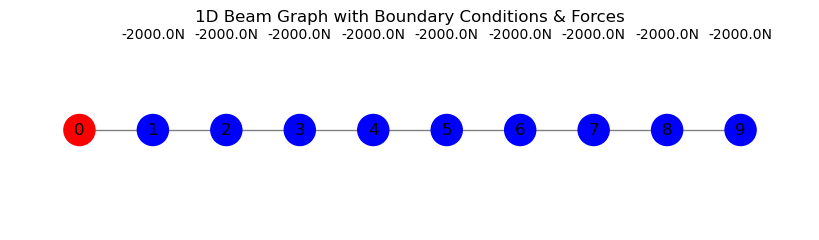

In [11]:
G = nx.Graph()
for i, pos in enumerate(node_pos.numpy()):
    G.add_node(i, pos=(pos[0], 0))  # Place nodes along x-axis

# Add edges
edge_list = edge_index.t().tolist()  # Convert tensor to list
G.add_edges_from(edge_list)

# Draw the graph with boundary conditions and forces
plt.figure(figsize=(8, 2))
pos = nx.get_node_attributes(G, 'pos')

# Node colors: fixed (red), free (blue)
node_colors = ["red" if bc[i] == 1 else "blue" for i in range(num_nodes)]

# Draw nodes
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=500, font_size=12)

# Annotate forces
for i, force in enumerate(forces.numpy()):
    if force != 0:
        plt.text(pos[i][0], pos[i][1] + 0.05, f"{force[0]:.1f}N", fontsize=10, color="black", ha="center")

plt.title("1D Beam Graph with Boundary Conditions & Forces")
plt.show()

In [30]:
graph = beam_graph

x_pos = graph.x[:,0:1]
bc = graph.x[:, 1:2]
q = graph.x[:, 2:3]

lbc = (bc == 1)
rbc = (bc == 2)
print(bc)


tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [2.]], grad_fn=<SliceBackward0>)


In [12]:

# Define the GNN model
class BeamGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BeamGNN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(input_dim, hidden_dim)
        self.conv2 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.conv3 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.conv4 = pyg_nn.GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = nn.functional.tanh(self.conv1(x, edge_index))
        x = nn.functional.tanh(self.conv2(x, edge_index))
        x = nn.functional.tanh(self.conv3(x, edge_index))        
        x = self.conv4(x, edge_index)  # Output: Predicted displacements
        return x

# Initialize the model
input_dim = 3  # [x-position, boundary condition flag, force]
hidden_dim = 32
output_dim = 2  # Predict u and m

model = BeamGNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [51]:
class PINN_graph():
    def __init__(self, graph):
        
        self.graph = graph

        self.input_dim = 3
        self.hidden_dim = 32
        self.output_dim = 2

        self.gnn = BeamGNN(self.input_dim, self.hidden_dim, self.output_dim)

        self.optimizer = torch.optim.Adam(self.gnn.parameters(), lr=0.01)

    def model_value(self, graph):
        out = self.gnn(graph)
        u = out[:, 0:1]
        m = out[:, 1:2]
        return u, m
    
    def loss_func(self, graph):
        u, m = self.model_value(graph)
        print(u)
        x_pos = graph.x[:,0:1]
        bc = graph.x[:, 1:2]
        q = graph.x[:, 2:3]

        lbc = (bc == 1)
        rbc = (bc == 2)

        u_x = torch.autograd.grad(u, x_pos, torch.ones_like(u), create_graph=True, allow_unused=True)[0]
        print(u_x)
        u_2x = torch.autograd.grad(u_x, x_pos, torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]

        m_x = torch.autograd.grad(m, x_pos, torch.ones_like(m), create_graph=True, retain_graph=True)[0]
        m_2x = torch.autograd.grad(m_x, x_pos, torch.ones_like(m_x), create_graph=True, retain_graph=True)[0]

        bc_loss = torch.mean(u[lbc]**2) + torch.mean(u_x[lbc]**2)
        bc_loss += torch.mean(m[rbc]**2) + torch.mean(m_x[rbc]**2)

        pde_loss = torch.mean(torch.pow(m_2x + q, 2))
        pde_loss += torch.mean(torch.pow(u_2x + m, 2))

        return pde_loss, bc_loss
    
    def train(self, epochs=1000):
        self.gnn.train()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            pde_loss, bc_loss = self.loss_func(self.graph)
            loss = pde_loss + bc_loss
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                print(f"Epoch: {epoch}, Loss: {'{:e}'.format(loss.item())}")
                print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}")



In [57]:
model = PINN_graph(beam_graph)
print(model.gnn)

BeamGNN(
  (conv1): GCNConv(3, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (conv4): GCNConv(32, 2)
)


In [54]:
model.train(2000)

tensor([[ 0.0129],
        [ 0.0092],
        [ 0.0022],
        [-0.0041],
        [-0.0043],
        [-0.0046],
        [-0.0066],
        [-0.0053],
        [-0.0049],
        [-0.0017]], grad_fn=<SliceBackward0>)
None


TypeError: ones_like(): argument 'input' (position 1) must be Tensor, not NoneType

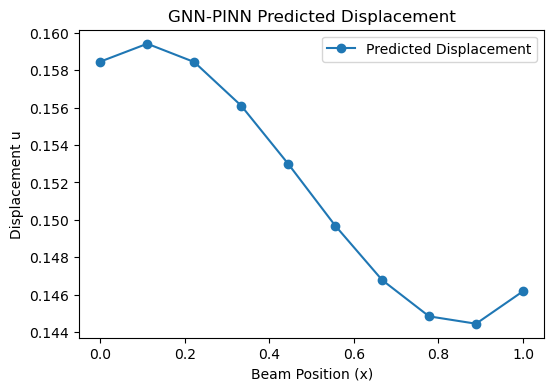

In [21]:
import matplotlib.pyplot as plt

# Get predictions
with torch.no_grad():
    u_pred = model(beam_graph).numpy()

# Plot displacement along the beam
plt.figure(figsize=(6, 4))
plt.plot(beam_graph.x[:, 0], u_pred, 'o-', label="Predicted Displacement")
plt.xlabel("Beam Position (x)")
plt.ylabel("Displacement u")
plt.title("GNN-PINN Predicted Displacement")
plt.legend()
plt.show()
